### PSF Investigation

In [1]:
# Imports
from astropy.table import Table
import lsst.daf.butler as dafButler
import glob
import lsst.afw.table as afwTable
import matplotlib as mpl
import matplotlib.pyplot as plt
from modelling_research.plotting import plotjoint_running_percentiles
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [2]:
# Config
hsc = True
overwrite = False
gen2to3 = False
filter_inexact_psf = True
filter_interpolated = True
midfix = '_gen2to3' if gen2to3 else ''
savepre = (f'/project/dtaranu/{"hsc" if hsc else "dc2_gen3"}'
           f'/w_2021_{"26" if hsc else "24"}{midfix}_coaddpsf/')
if not os.path.isdir(savepre):
    os.mkdir(savepre)
savepost = '.parq'
bands = ['g', 'r', 'i']
if hsc:
    butler = dafButler.Butler('/repo/main', collections='HSC/runs/RC2/w_2021_26/DM-30867')
    n_patches = 81
    scale_pix = 0.168
    tracts = [9615, 9697]
    # It's pointless to include COSMOS if these flags are used as 90%+ of coadd stars have them
    if not filter_inexact_psf and not filter_interpolated:
        tracts.append(9813)
    limxs = {band: x for band, x in zip(bands, ((0.525, 1.275), (0.35, 1.0), (0.35, 1.0),))}
    limsfrac = (-0.05, 0.05)
else:
    butler = dafButler.Butler('/repo/dc2', collections='2.2i/runs/test-med-1/w_2021_24/DM-30674')
    tracts = [3828, 3829]
    n_patches = 49
    scale_pix = 0.2
    filter_inexact_psf = True
    filter_interpolated = True
    limxs = {band: x for band, x in zip(bands, ((0.6, 1.2), (0.65, 0.95), (0.65, 0.95),))}
    limsfrac = (-0.025, 0.025)
patches = list(range(n_patches))

In [3]:
# Plot settings
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['figure.figsize'] = 10, 20
sns.set(rc={'axes.facecolor': '0.85', 'figure.facecolor': 'w'})
sns.set_style('dark')

In [4]:
# Take a sourceCatalog and turn it into a condensed parquet table
def make_summary(butler, type_cat=None, **kwargs):
    if type_cat is None:
        type_cat = 'deepCoadd_meas'
    try:
        src = butler.get(type_cat, **kwargs)
    except Exception as e:
        print(f'Failed to butler.get({type_cat}, {kwargs}) due to {e}')
        return None

    mask = src['calib_psf_used']
    n_psf = np.sum(mask)
    stars = src[mask]
    
    mask = None
    flags = [
        'base_PixelFlags_flag_clipped',
        'base_PixelFlags_flag_saturated',
    ]
    if filter_inexact_psf:
        flags.append('base_PixelFlags_flag_inexact_psf')
    if filter_interpolated:
        flags.append('base_PixelFlags_flag_interpolated')
    for flag in flags:
        if mask is None:
            mask = ~stars[flag]
        else:
            mask = mask & ~stars[flag]
        print(f'Flag {flag} filters {np.sum(stars[flag])}/{n_psf} for dataId: {kwargs}')
    print(f'Selected {np.sum(mask)}/{n_psf}')
    if np.sum(mask)==0:
        print('No data')
        return None
    stars = stars[mask]
    starIxx = stars['base_SdssShape_xx']
    starIxy = stars['base_SdssShape_xy']
    starIyy = stars['base_SdssShape_yy']
    modelIxx = stars['base_SdssShape_psf_xx']
    modelIxy = stars['base_SdssShape_psf_xy']
    modelIyy = stars['base_SdssShape_psf_yy']
    data = {}
    data['starE1'] = (starIxx-starIyy)/(starIxx+starIyy)
    data['starE2'] = (2*starIxy)/(starIxx+starIyy)
    data['starSize'] = np.sqrt(0.5*(starIxx + starIyy))*2.354820045*scale_pix
    data['modelE1'] = (modelIxx-modelIyy)/(modelIxx+modelIyy)
    data['modelE2'] = (2*modelIxy)/(modelIxx+modelIyy)
    data['modelSize'] = np.sqrt(0.5*(modelIxx + modelIyy))*2.354820045*scale_pix
    data['ra'] = [a.getCoord().getRa().asDegrees() for a in stars]
    data['dec'] = [a.getCoord().getDec().asDegrees() for a in stars]
    data['fluxPsf'] = stars['base_PsfFlux_instFlux']
    data['fluxPsfErr'] = stars['base_PsfFlux_instFluxErr']
    data['fluxCmodel'] = stars['modelfit_CModel_instFlux']
    data['fluxCmodelErr'] = stars['modelfit_CModel_instFluxErr']
    df = pd.DataFrame(data)
    return df

def make_table(band, tracts, patches, **kwargs):
    data=[]
    for tract in tracts:
        for patch in patches:
            print(f'Making summary for band={band}, tract={tract}, patch={patch}')
            result = make_summary(band=band, tract=tract, patch=patch, **kwargs)
            if result is None:
                continue
            data.append(result)
    table = pd.concat(data)
    return table

In [5]:
# Read/write data
data = {}
for band in bands:
    desc = (f'{",".join((str(x) for x in tracts))}_{band}_filt_inexact'
            f'{int(filter_inexact_psf)}_interp{int(filter_interpolated)}')
    savefile = f'{savepre}{desc}{savepost}'
    if overwrite or not os.path.exists(savefile):
        print(f'Generating {savefile} for band={band}, tracts={tracts}, patches={patches}')
        table = make_table(band, tracts, patches, butler=butler)
        table.to_parquet(savefile)
        data[band] = table
    else:
        print(f'Reading {savefile}')
        data[band] = pd.read_parquet(savefile)

Generating /project/dtaranu/hsc/w_2021_26_coaddpsf/9615,9697_g_filt_inexact1_interp1.parq for band=g, tracts=[9615, 9697], patches=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
Making summary for band=g, tract=9615, patch=0
Failed to butler.get(deepCoadd_meas, {'band': 'g', 'tract': 9615, 'patch': 0}) due to Dataset deepCoadd_meas with data ID {band: 'g', skymap: 'hsc_rings_v1', tract: 9615, patch: 0} could not be found in collections [HSC/runs/RC2/w_2021_26/DM-30867].
Making summary for band=g, tract=9615, patch=1
Failed to butler.get(deepCoadd_meas, {'band': 'g', 'tract': 9615, 'patch': 1}) due to Dataset deepCoadd_meas with data ID {band: 'g', skymap: 'hsc_rings_v1', tract: 9615, patch: 1} could not be found in collect

Flag base_PixelFlags_flag_clipped filters 15/420 for dataId: {'band': 'g', 'tract': 9615, 'patch': 22}
Flag base_PixelFlags_flag_saturated filters 6/420 for dataId: {'band': 'g', 'tract': 9615, 'patch': 22}
Flag base_PixelFlags_flag_inexact_psf filters 154/420 for dataId: {'band': 'g', 'tract': 9615, 'patch': 22}
Flag base_PixelFlags_flag_interpolated filters 63/420 for dataId: {'band': 'g', 'tract': 9615, 'patch': 22}
Selected 222/420
Making summary for band=g, tract=9615, patch=23
Flag base_PixelFlags_flag_clipped filters 8/411 for dataId: {'band': 'g', 'tract': 9615, 'patch': 23}
Flag base_PixelFlags_flag_saturated filters 8/411 for dataId: {'band': 'g', 'tract': 9615, 'patch': 23}
Flag base_PixelFlags_flag_inexact_psf filters 185/411 for dataId: {'band': 'g', 'tract': 9615, 'patch': 23}
Flag base_PixelFlags_flag_interpolated filters 72/411 for dataId: {'band': 'g', 'tract': 9615, 'patch': 23}
Selected 189/411
Making summary for band=g, tract=9615, patch=24
Failed to butler.get(deep

Flag base_PixelFlags_flag_clipped filters 18/449 for dataId: {'band': 'g', 'tract': 9615, 'patch': 46}
Flag base_PixelFlags_flag_saturated filters 7/449 for dataId: {'band': 'g', 'tract': 9615, 'patch': 46}
Flag base_PixelFlags_flag_inexact_psf filters 193/449 for dataId: {'band': 'g', 'tract': 9615, 'patch': 46}
Flag base_PixelFlags_flag_interpolated filters 102/449 for dataId: {'band': 'g', 'tract': 9615, 'patch': 46}
Selected 195/449
Making summary for band=g, tract=9615, patch=47
Failed to butler.get(deepCoadd_meas, {'band': 'g', 'tract': 9615, 'patch': 47}) due to Dataset deepCoadd_meas with data ID {band: 'g', skymap: 'hsc_rings_v1', tract: 9615, patch: 47} could not be found in collections [HSC/runs/RC2/w_2021_26/DM-30867].
Making summary for band=g, tract=9615, patch=48
Failed to butler.get(deepCoadd_meas, {'band': 'g', 'tract': 9615, 'patch': 48}) due to Dataset deepCoadd_meas with data ID {band: 'g', skymap: 'hsc_rings_v1', tract: 9615, patch: 48} could not be found in collec

Flag base_PixelFlags_flag_clipped filters 5/428 for dataId: {'band': 'g', 'tract': 9615, 'patch': 67}
Flag base_PixelFlags_flag_saturated filters 9/428 for dataId: {'band': 'g', 'tract': 9615, 'patch': 67}
Flag base_PixelFlags_flag_inexact_psf filters 116/428 for dataId: {'band': 'g', 'tract': 9615, 'patch': 67}
Flag base_PixelFlags_flag_interpolated filters 85/428 for dataId: {'band': 'g', 'tract': 9615, 'patch': 67}
Selected 251/428
Making summary for band=g, tract=9615, patch=68
Flag base_PixelFlags_flag_clipped filters 4/456 for dataId: {'band': 'g', 'tract': 9615, 'patch': 68}
Flag base_PixelFlags_flag_saturated filters 11/456 for dataId: {'band': 'g', 'tract': 9615, 'patch': 68}
Flag base_PixelFlags_flag_inexact_psf filters 125/456 for dataId: {'band': 'g', 'tract': 9615, 'patch': 68}
Flag base_PixelFlags_flag_interpolated filters 47/456 for dataId: {'band': 'g', 'tract': 9615, 'patch': 68}
Selected 293/456
Making summary for band=g, tract=9615, patch=69
Failed to butler.get(deep

Flag base_PixelFlags_flag_clipped filters 82/287 for dataId: {'band': 'g', 'tract': 9697, 'patch': 14}
Flag base_PixelFlags_flag_saturated filters 16/287 for dataId: {'band': 'g', 'tract': 9697, 'patch': 14}
Flag base_PixelFlags_flag_inexact_psf filters 173/287 for dataId: {'band': 'g', 'tract': 9697, 'patch': 14}
Flag base_PixelFlags_flag_interpolated filters 83/287 for dataId: {'band': 'g', 'tract': 9697, 'patch': 14}
Selected 92/287
Making summary for band=g, tract=9697, patch=15
Flag base_PixelFlags_flag_clipped filters 46/259 for dataId: {'band': 'g', 'tract': 9697, 'patch': 15}
Flag base_PixelFlags_flag_saturated filters 3/259 for dataId: {'band': 'g', 'tract': 9697, 'patch': 15}
Flag base_PixelFlags_flag_inexact_psf filters 129/259 for dataId: {'band': 'g', 'tract': 9697, 'patch': 15}
Flag base_PixelFlags_flag_interpolated filters 55/259 for dataId: {'band': 'g', 'tract': 9697, 'patch': 15}
Selected 103/259
Making summary for band=g, tract=9697, patch=16
Failed to butler.get(dee

Failed to butler.get(deepCoadd_meas, {'band': 'g', 'tract': 9697, 'patch': 41}) due to Dataset deepCoadd_meas with data ID {band: 'g', skymap: 'hsc_rings_v1', tract: 9697, patch: 41} could not be found in collections [HSC/runs/RC2/w_2021_26/DM-30867].
Making summary for band=g, tract=9697, patch=42
Failed to butler.get(deepCoadd_meas, {'band': 'g', 'tract': 9697, 'patch': 42}) due to Dataset deepCoadd_meas with data ID {band: 'g', skymap: 'hsc_rings_v1', tract: 9697, patch: 42} could not be found in collections [HSC/runs/RC2/w_2021_26/DM-30867].
Making summary for band=g, tract=9697, patch=43
Failed to butler.get(deepCoadd_meas, {'band': 'g', 'tract': 9697, 'patch': 43}) due to Dataset deepCoadd_meas with data ID {band: 'g', skymap: 'hsc_rings_v1', tract: 9697, patch: 43} could not be found in collections [HSC/runs/RC2/w_2021_26/DM-30867].
Making summary for band=g, tract=9697, patch=44
Failed to butler.get(deepCoadd_meas, {'band': 'g', 'tract': 9697, 'patch': 44}) due to Dataset deepC

Flag base_PixelFlags_flag_clipped filters 20/276 for dataId: {'band': 'g', 'tract': 9697, 'patch': 67}
Flag base_PixelFlags_flag_saturated filters 0/276 for dataId: {'band': 'g', 'tract': 9697, 'patch': 67}
Flag base_PixelFlags_flag_inexact_psf filters 149/276 for dataId: {'band': 'g', 'tract': 9697, 'patch': 67}
Flag base_PixelFlags_flag_interpolated filters 86/276 for dataId: {'band': 'g', 'tract': 9697, 'patch': 67}
Selected 88/276
Making summary for band=g, tract=9697, patch=68
Flag base_PixelFlags_flag_clipped filters 27/309 for dataId: {'band': 'g', 'tract': 9697, 'patch': 68}
Flag base_PixelFlags_flag_saturated filters 3/309 for dataId: {'band': 'g', 'tract': 9697, 'patch': 68}
Flag base_PixelFlags_flag_inexact_psf filters 170/309 for dataId: {'band': 'g', 'tract': 9697, 'patch': 68}
Flag base_PixelFlags_flag_interpolated filters 90/309 for dataId: {'band': 'g', 'tract': 9697, 'patch': 68}
Selected 92/309
Making summary for band=g, tract=9697, patch=69
Failed to butler.get(deepC

Flag base_PixelFlags_flag_clipped filters 24/652 for dataId: {'band': 'r', 'tract': 9615, 'patch': 8}
Flag base_PixelFlags_flag_saturated filters 25/652 for dataId: {'band': 'r', 'tract': 9615, 'patch': 8}
Flag base_PixelFlags_flag_inexact_psf filters 206/652 for dataId: {'band': 'r', 'tract': 9615, 'patch': 8}
Flag base_PixelFlags_flag_interpolated filters 124/652 for dataId: {'band': 'r', 'tract': 9615, 'patch': 8}
Selected 374/652
Making summary for band=r, tract=9615, patch=9
Flag base_PixelFlags_flag_clipped filters 48/595 for dataId: {'band': 'r', 'tract': 9615, 'patch': 9}
Flag base_PixelFlags_flag_saturated filters 21/595 for dataId: {'band': 'r', 'tract': 9615, 'patch': 9}
Flag base_PixelFlags_flag_inexact_psf filters 235/595 for dataId: {'band': 'r', 'tract': 9615, 'patch': 9}
Flag base_PixelFlags_flag_interpolated filters 101/595 for dataId: {'band': 'r', 'tract': 9615, 'patch': 9}
Selected 302/595
Making summary for band=r, tract=9615, patch=10
Failed to butler.get(deepCoad

Flag base_PixelFlags_flag_clipped filters 49/638 for dataId: {'band': 'r', 'tract': 9615, 'patch': 34}
Flag base_PixelFlags_flag_saturated filters 30/638 for dataId: {'band': 'r', 'tract': 9615, 'patch': 34}
Flag base_PixelFlags_flag_inexact_psf filters 233/638 for dataId: {'band': 'r', 'tract': 9615, 'patch': 34}
Flag base_PixelFlags_flag_interpolated filters 87/638 for dataId: {'band': 'r', 'tract': 9615, 'patch': 34}
Selected 351/638
Making summary for band=r, tract=9615, patch=35
Failed to butler.get(deepCoadd_meas, {'band': 'r', 'tract': 9615, 'patch': 35}) due to Dataset deepCoadd_meas with data ID {band: 'r', skymap: 'hsc_rings_v1', tract: 9615, patch: 35} could not be found in collections [HSC/runs/RC2/w_2021_26/DM-30867].
Making summary for band=r, tract=9615, patch=36
Failed to butler.get(deepCoadd_meas, {'band': 'r', 'tract': 9615, 'patch': 36}) due to Dataset deepCoadd_meas with data ID {band: 'r', skymap: 'hsc_rings_v1', tract: 9615, patch: 36} could not be found in collec

Flag base_PixelFlags_flag_clipped filters 29/626 for dataId: {'band': 'r', 'tract': 9615, 'patch': 58}
Flag base_PixelFlags_flag_saturated filters 24/626 for dataId: {'band': 'r', 'tract': 9615, 'patch': 58}
Flag base_PixelFlags_flag_inexact_psf filters 235/626 for dataId: {'band': 'r', 'tract': 9615, 'patch': 58}
Flag base_PixelFlags_flag_interpolated filters 123/626 for dataId: {'band': 'r', 'tract': 9615, 'patch': 58}
Selected 318/626
Making summary for band=r, tract=9615, patch=59
Flag base_PixelFlags_flag_clipped filters 28/647 for dataId: {'band': 'r', 'tract': 9615, 'patch': 59}
Flag base_PixelFlags_flag_saturated filters 32/647 for dataId: {'band': 'r', 'tract': 9615, 'patch': 59}
Flag base_PixelFlags_flag_inexact_psf filters 207/647 for dataId: {'band': 'r', 'tract': 9615, 'patch': 59}
Flag base_PixelFlags_flag_interpolated filters 100/647 for dataId: {'band': 'r', 'tract': 9615, 'patch': 59}
Selected 391/647
Making summary for band=r, tract=9615, patch=60
Failed to butler.get

Flag base_PixelFlags_flag_clipped filters 9/654 for dataId: {'band': 'r', 'tract': 9615, 'patch': 78}
Flag base_PixelFlags_flag_saturated filters 40/654 for dataId: {'band': 'r', 'tract': 9615, 'patch': 78}
Flag base_PixelFlags_flag_inexact_psf filters 182/654 for dataId: {'band': 'r', 'tract': 9615, 'patch': 78}
Flag base_PixelFlags_flag_interpolated filters 85/654 for dataId: {'band': 'r', 'tract': 9615, 'patch': 78}
Selected 418/654
Making summary for band=r, tract=9615, patch=79
Flag base_PixelFlags_flag_clipped filters 1/549 for dataId: {'band': 'r', 'tract': 9615, 'patch': 79}
Flag base_PixelFlags_flag_saturated filters 30/549 for dataId: {'band': 'r', 'tract': 9615, 'patch': 79}
Flag base_PixelFlags_flag_inexact_psf filters 117/549 for dataId: {'band': 'r', 'tract': 9615, 'patch': 79}
Flag base_PixelFlags_flag_interpolated filters 71/549 for dataId: {'band': 'r', 'tract': 9615, 'patch': 79}
Selected 387/549
Making summary for band=r, tract=9615, patch=80
Failed to butler.get(dee

Failed to butler.get(deepCoadd_meas, {'band': 'r', 'tract': 9697, 'patch': 23}) due to Dataset deepCoadd_meas with data ID {band: 'r', skymap: 'hsc_rings_v1', tract: 9697, patch: 23} could not be found in collections [HSC/runs/RC2/w_2021_26/DM-30867].
Making summary for band=r, tract=9697, patch=24
Failed to butler.get(deepCoadd_meas, {'band': 'r', 'tract': 9697, 'patch': 24}) due to Dataset deepCoadd_meas with data ID {band: 'r', skymap: 'hsc_rings_v1', tract: 9697, patch: 24} could not be found in collections [HSC/runs/RC2/w_2021_26/DM-30867].
Making summary for band=r, tract=9697, patch=25
Failed to butler.get(deepCoadd_meas, {'band': 'r', 'tract': 9697, 'patch': 25}) due to Dataset deepCoadd_meas with data ID {band: 'r', skymap: 'hsc_rings_v1', tract: 9697, patch: 25} could not be found in collections [HSC/runs/RC2/w_2021_26/DM-30867].
Making summary for band=r, tract=9697, patch=26
Failed to butler.get(deepCoadd_meas, {'band': 'r', 'tract': 9697, 'patch': 26}) due to Dataset deepC

Flag base_PixelFlags_flag_clipped filters 47/476 for dataId: {'band': 'r', 'tract': 9697, 'patch': 54}
Flag base_PixelFlags_flag_saturated filters 20/476 for dataId: {'band': 'r', 'tract': 9697, 'patch': 54}
Flag base_PixelFlags_flag_inexact_psf filters 212/476 for dataId: {'band': 'r', 'tract': 9697, 'patch': 54}
Flag base_PixelFlags_flag_interpolated filters 104/476 for dataId: {'band': 'r', 'tract': 9697, 'patch': 54}
Selected 215/476
Making summary for band=r, tract=9697, patch=55
Failed to butler.get(deepCoadd_meas, {'band': 'r', 'tract': 9697, 'patch': 55}) due to Dataset deepCoadd_meas with data ID {band: 'r', skymap: 'hsc_rings_v1', tract: 9697, patch: 55} could not be found in collections [HSC/runs/RC2/w_2021_26/DM-30867].
Making summary for band=r, tract=9697, patch=56
Failed to butler.get(deepCoadd_meas, {'band': 'r', 'tract': 9697, 'patch': 56}) due to Dataset deepCoadd_meas with data ID {band: 'r', skymap: 'hsc_rings_v1', tract: 9697, patch: 56} could not be found in colle

Flag base_PixelFlags_flag_clipped filters 9/506 for dataId: {'band': 'r', 'tract': 9697, 'patch': 79}
Flag base_PixelFlags_flag_saturated filters 11/506 for dataId: {'band': 'r', 'tract': 9697, 'patch': 79}
Flag base_PixelFlags_flag_inexact_psf filters 180/506 for dataId: {'band': 'r', 'tract': 9697, 'patch': 79}
Flag base_PixelFlags_flag_interpolated filters 97/506 for dataId: {'band': 'r', 'tract': 9697, 'patch': 79}
Selected 273/506
Making summary for band=r, tract=9697, patch=80
Failed to butler.get(deepCoadd_meas, {'band': 'r', 'tract': 9697, 'patch': 80}) due to Dataset deepCoadd_meas with data ID {band: 'r', skymap: 'hsc_rings_v1', tract: 9697, patch: 80} could not be found in collections [HSC/runs/RC2/w_2021_26/DM-30867].
Generating /project/dtaranu/hsc/w_2021_26_coaddpsf/9615,9697_i_filt_inexact1_interp1.parq for band=i, tracts=[9615, 9697], patches=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34

Flag base_PixelFlags_flag_clipped filters 59/693 for dataId: {'band': 'i', 'tract': 9615, 'patch': 20}
Flag base_PixelFlags_flag_saturated filters 41/693 for dataId: {'band': 'i', 'tract': 9615, 'patch': 20}
Flag base_PixelFlags_flag_inexact_psf filters 395/693 for dataId: {'band': 'i', 'tract': 9615, 'patch': 20}
Flag base_PixelFlags_flag_interpolated filters 244/693 for dataId: {'band': 'i', 'tract': 9615, 'patch': 20}
Selected 189/693
Making summary for band=i, tract=9615, patch=21
Failed to butler.get(deepCoadd_meas, {'band': 'i', 'tract': 9615, 'patch': 21}) due to Dataset deepCoadd_meas with data ID {band: 'i', skymap: 'hsc_rings_v1', tract: 9615, patch: 21} could not be found in collections [HSC/runs/RC2/w_2021_26/DM-30867].
Making summary for band=i, tract=9615, patch=22
Flag base_PixelFlags_flag_clipped filters 63/695 for dataId: {'band': 'i', 'tract': 9615, 'patch': 22}
Flag base_PixelFlags_flag_saturated filters 43/695 for dataId: {'band': 'i', 'tract': 9615, 'patch': 22}
Fl

Flag base_PixelFlags_flag_clipped filters 60/671 for dataId: {'band': 'i', 'tract': 9615, 'patch': 46}
Flag base_PixelFlags_flag_saturated filters 57/671 for dataId: {'band': 'i', 'tract': 9615, 'patch': 46}
Flag base_PixelFlags_flag_inexact_psf filters 383/671 for dataId: {'band': 'i', 'tract': 9615, 'patch': 46}
Flag base_PixelFlags_flag_interpolated filters 224/671 for dataId: {'band': 'i', 'tract': 9615, 'patch': 46}
Selected 188/671
Making summary for band=i, tract=9615, patch=47
Failed to butler.get(deepCoadd_meas, {'band': 'i', 'tract': 9615, 'patch': 47}) due to Dataset deepCoadd_meas with data ID {band: 'i', skymap: 'hsc_rings_v1', tract: 9615, patch: 47} could not be found in collections [HSC/runs/RC2/w_2021_26/DM-30867].
Making summary for band=i, tract=9615, patch=48
Failed to butler.get(deepCoadd_meas, {'band': 'i', 'tract': 9615, 'patch': 48}) due to Dataset deepCoadd_meas with data ID {band: 'i', skymap: 'hsc_rings_v1', tract: 9615, patch: 48} could not be found in colle

Flag base_PixelFlags_flag_clipped filters 30/693 for dataId: {'band': 'i', 'tract': 9615, 'patch': 67}
Flag base_PixelFlags_flag_saturated filters 42/693 for dataId: {'band': 'i', 'tract': 9615, 'patch': 67}
Flag base_PixelFlags_flag_inexact_psf filters 258/693 for dataId: {'band': 'i', 'tract': 9615, 'patch': 67}
Flag base_PixelFlags_flag_interpolated filters 152/693 for dataId: {'band': 'i', 'tract': 9615, 'patch': 67}
Selected 343/693
Making summary for band=i, tract=9615, patch=68
Flag base_PixelFlags_flag_clipped filters 26/721 for dataId: {'band': 'i', 'tract': 9615, 'patch': 68}
Flag base_PixelFlags_flag_saturated filters 55/721 for dataId: {'band': 'i', 'tract': 9615, 'patch': 68}
Flag base_PixelFlags_flag_inexact_psf filters 246/721 for dataId: {'band': 'i', 'tract': 9615, 'patch': 68}
Flag base_PixelFlags_flag_interpolated filters 144/721 for dataId: {'band': 'i', 'tract': 9615, 'patch': 68}
Selected 381/721
Making summary for band=i, tract=9615, patch=69
Failed to butler.get

Failed to butler.get(deepCoadd_meas, {'band': 'i', 'tract': 9697, 'patch': 12}) due to Dataset deepCoadd_meas with data ID {band: 'i', skymap: 'hsc_rings_v1', tract: 9697, patch: 12} could not be found in collections [HSC/runs/RC2/w_2021_26/DM-30867].
Making summary for band=i, tract=9697, patch=13
Failed to butler.get(deepCoadd_meas, {'band': 'i', 'tract': 9697, 'patch': 13}) due to Dataset deepCoadd_meas with data ID {band: 'i', skymap: 'hsc_rings_v1', tract: 9697, patch: 13} could not be found in collections [HSC/runs/RC2/w_2021_26/DM-30867].
Making summary for band=i, tract=9697, patch=14
Flag base_PixelFlags_flag_clipped filters 114/633 for dataId: {'band': 'i', 'tract': 9697, 'patch': 14}
Flag base_PixelFlags_flag_saturated filters 71/633 for dataId: {'band': 'i', 'tract': 9697, 'patch': 14}
Flag base_PixelFlags_flag_inexact_psf filters 348/633 for dataId: {'band': 'i', 'tract': 9697, 'patch': 14}
Flag base_PixelFlags_flag_interpolated filters 178/633 for dataId: {'band': 'i', 't

Failed to butler.get(deepCoadd_meas, {'band': 'i', 'tract': 9697, 'patch': 39}) due to Dataset deepCoadd_meas with data ID {band: 'i', skymap: 'hsc_rings_v1', tract: 9697, patch: 39} could not be found in collections [HSC/runs/RC2/w_2021_26/DM-30867].
Making summary for band=i, tract=9697, patch=40
Failed to butler.get(deepCoadd_meas, {'band': 'i', 'tract': 9697, 'patch': 40}) due to Dataset deepCoadd_meas with data ID {band: 'i', skymap: 'hsc_rings_v1', tract: 9697, patch: 40} could not be found in collections [HSC/runs/RC2/w_2021_26/DM-30867].
Making summary for band=i, tract=9697, patch=41
Failed to butler.get(deepCoadd_meas, {'band': 'i', 'tract': 9697, 'patch': 41}) due to Dataset deepCoadd_meas with data ID {band: 'i', skymap: 'hsc_rings_v1', tract: 9697, patch: 41} could not be found in collections [HSC/runs/RC2/w_2021_26/DM-30867].
Making summary for band=i, tract=9697, patch=42
Failed to butler.get(deepCoadd_meas, {'band': 'i', 'tract': 9697, 'patch': 42}) due to Dataset deepC

Flag base_PixelFlags_flag_clipped filters 70/630 for dataId: {'band': 'i', 'tract': 9697, 'patch': 67}
Flag base_PixelFlags_flag_saturated filters 39/630 for dataId: {'band': 'i', 'tract': 9697, 'patch': 67}
Flag base_PixelFlags_flag_inexact_psf filters 407/630 for dataId: {'band': 'i', 'tract': 9697, 'patch': 67}
Flag base_PixelFlags_flag_interpolated filters 213/630 for dataId: {'band': 'i', 'tract': 9697, 'patch': 67}
Selected 158/630
Making summary for band=i, tract=9697, patch=68
Flag base_PixelFlags_flag_clipped filters 33/669 for dataId: {'band': 'i', 'tract': 9697, 'patch': 68}
Flag base_PixelFlags_flag_saturated filters 48/669 for dataId: {'band': 'i', 'tract': 9697, 'patch': 68}
Flag base_PixelFlags_flag_inexact_psf filters 368/669 for dataId: {'band': 'i', 'tract': 9697, 'patch': 68}
Flag base_PixelFlags_flag_interpolated filters 171/669 for dataId: {'band': 'i', 'tract': 9697, 'patch': 68}
Selected 242/669
Making summary for band=i, tract=9697, patch=69
Failed to butler.get

g Lanczos5 PSF model residuals (N=9970)


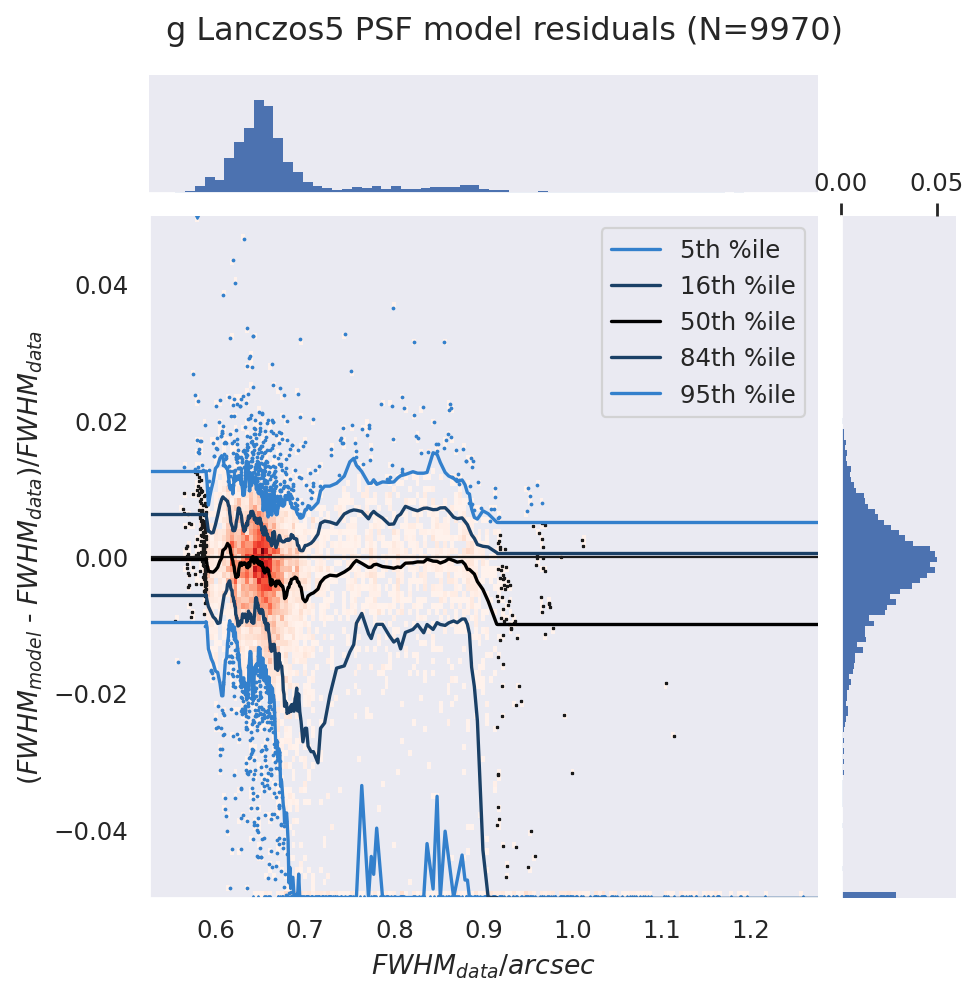

r Lanczos5 PSF model residuals (N=15681)


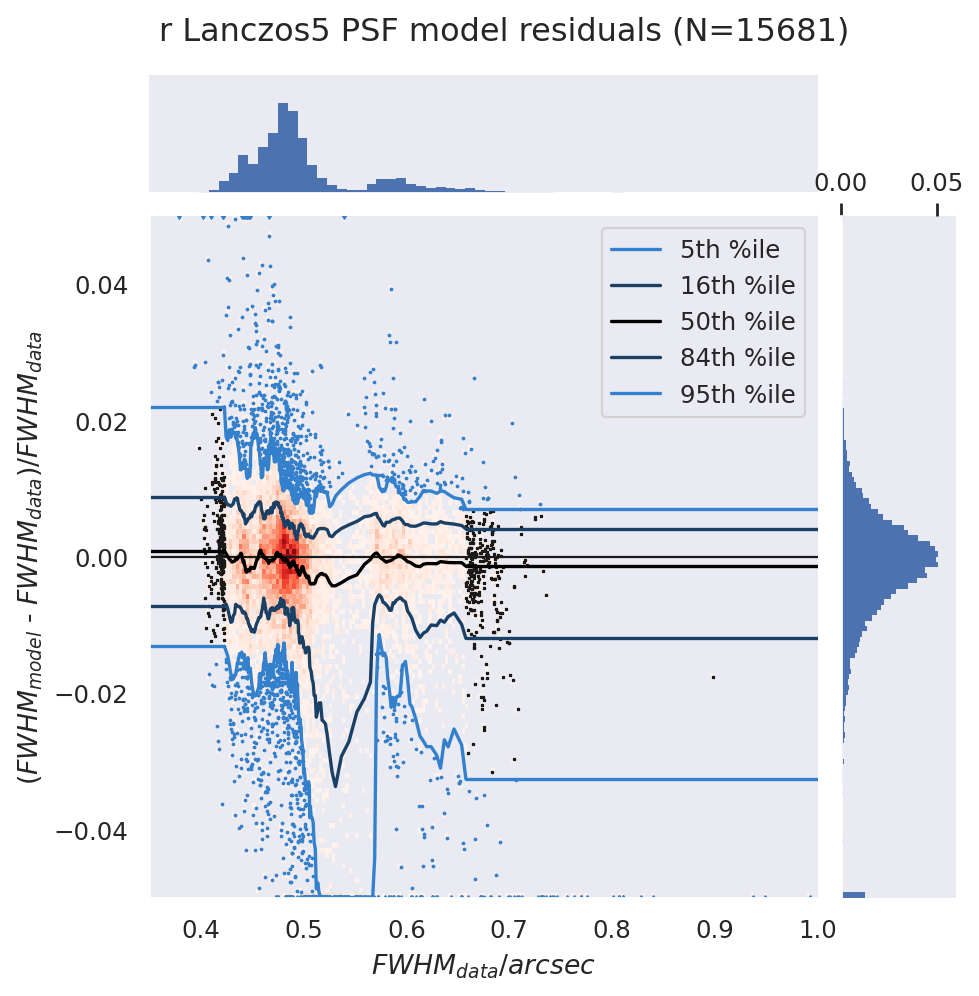

i Lanczos5 PSF model residuals (N=13380)


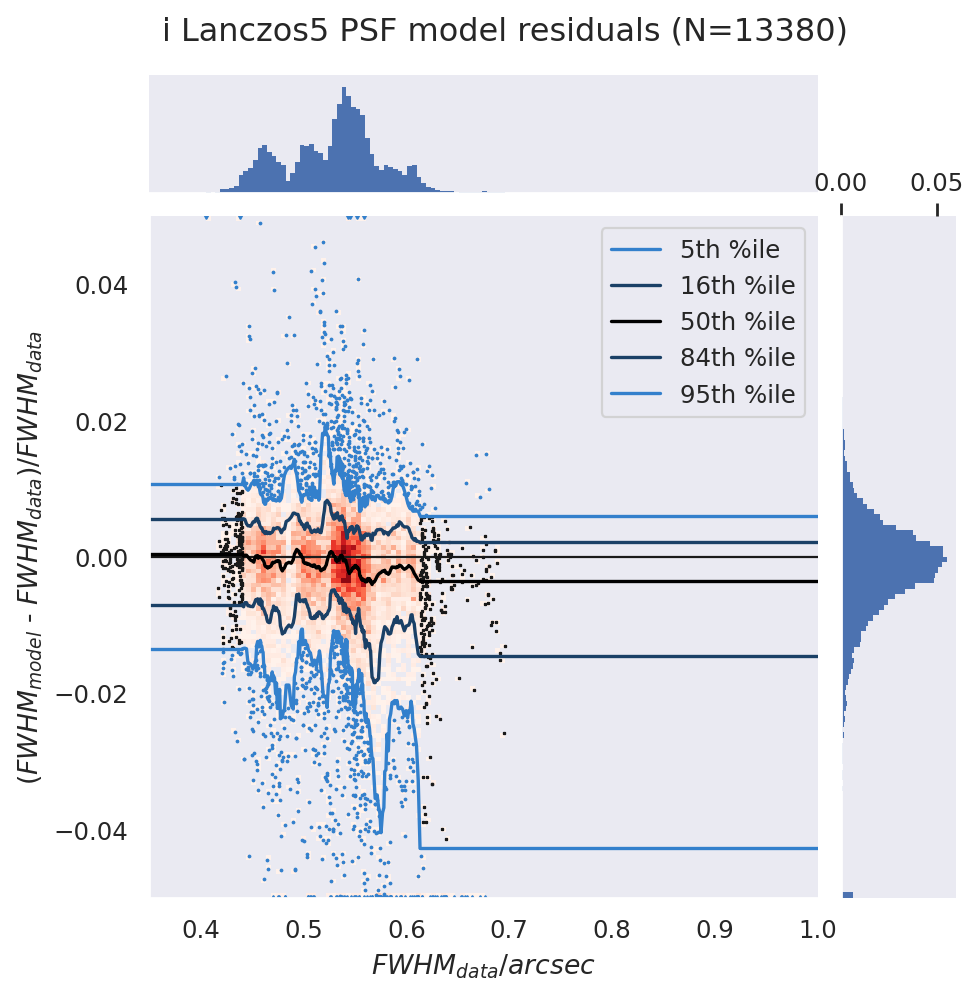

g Lanczos5, 0.554 <= FWHM <= 0.636, N=2491


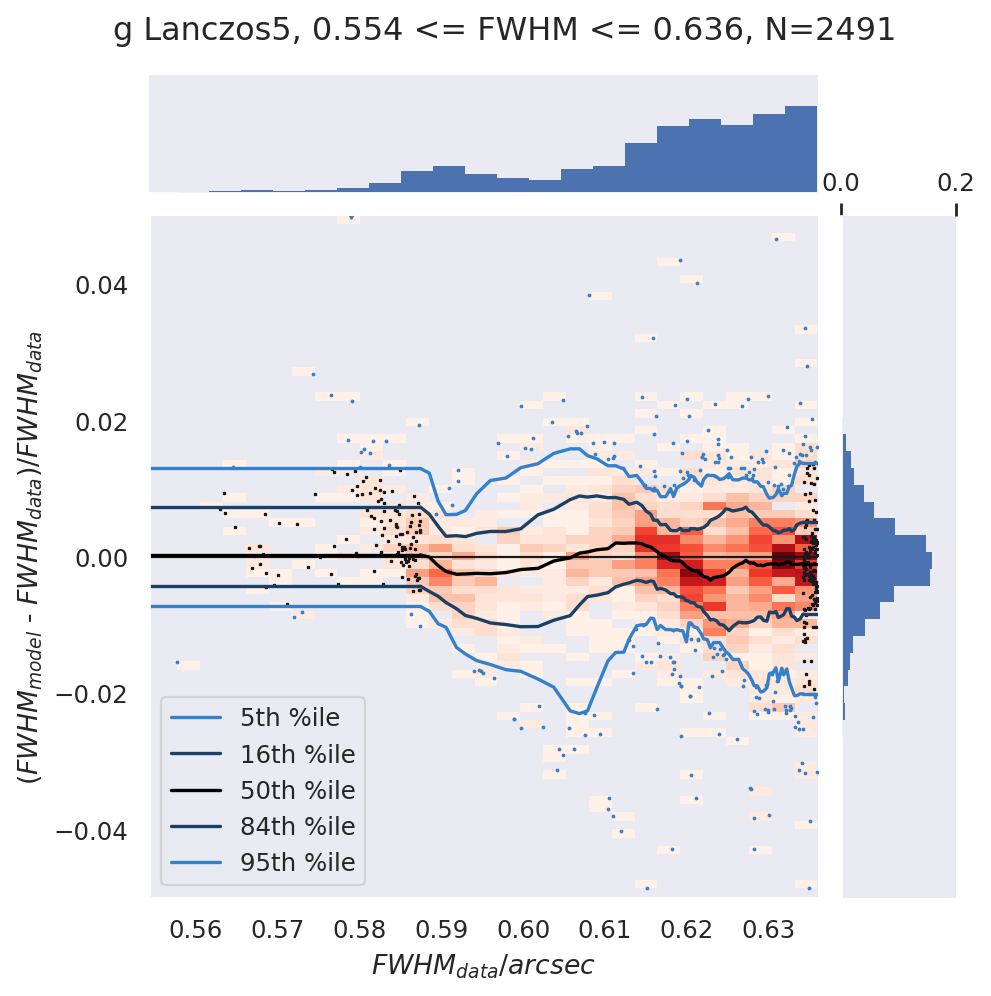

g Lanczos5, 0.636 <= FWHM <= 0.655, N=2491


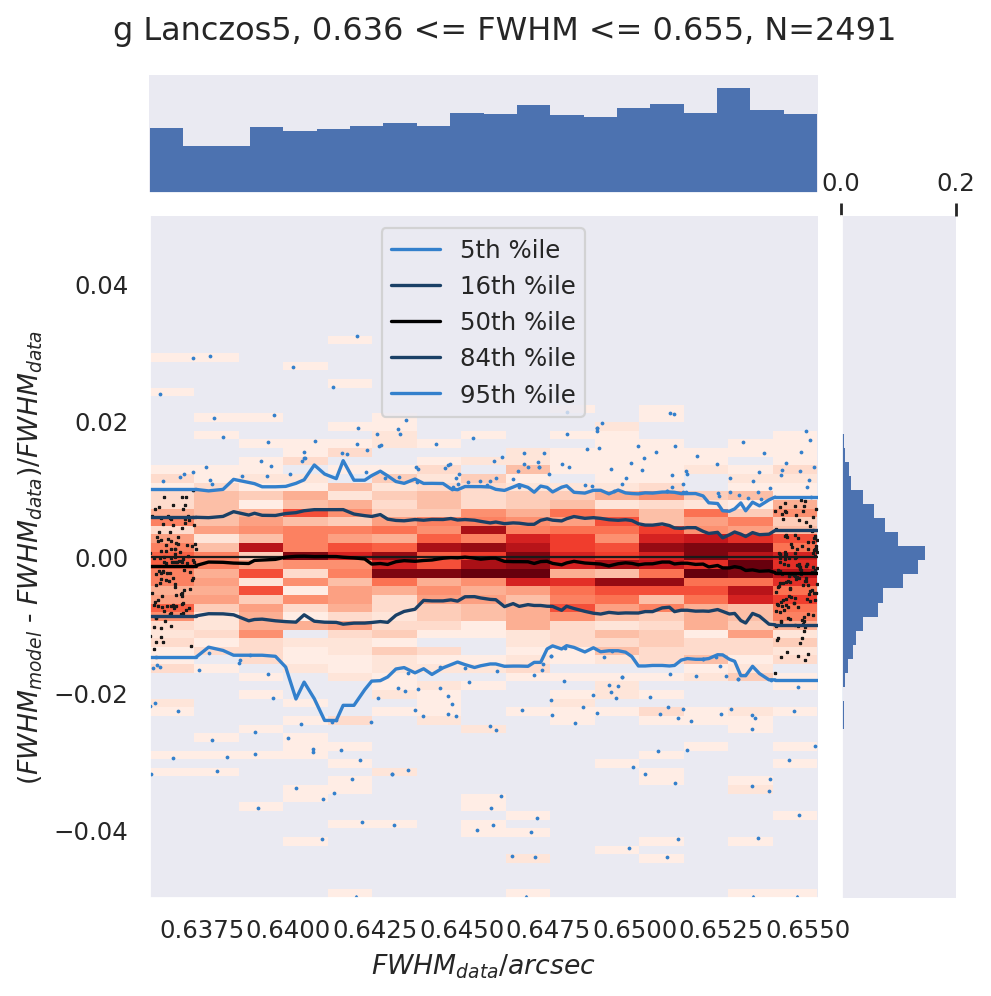

g Lanczos5, 0.655 <= FWHM <= 0.683, N=2492


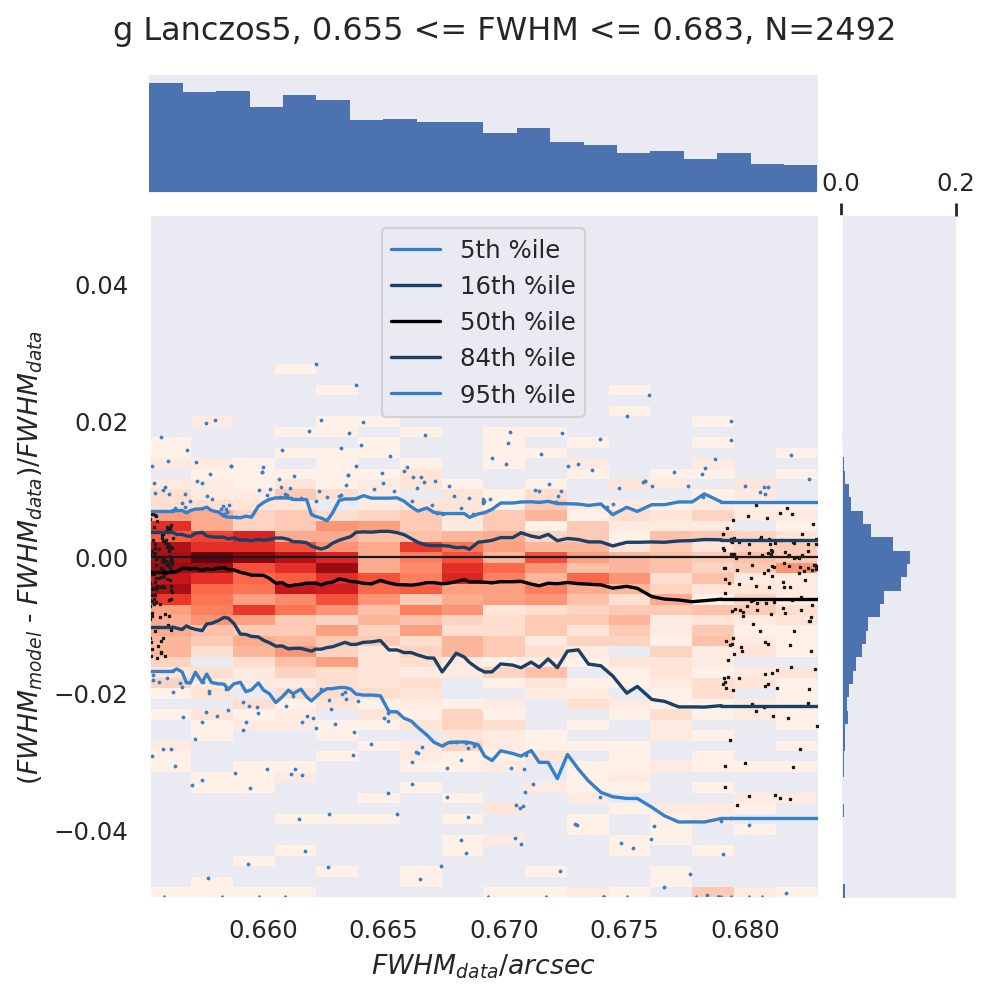

g Lanczos5, 0.683 <= FWHM <= 1.259, N=2491


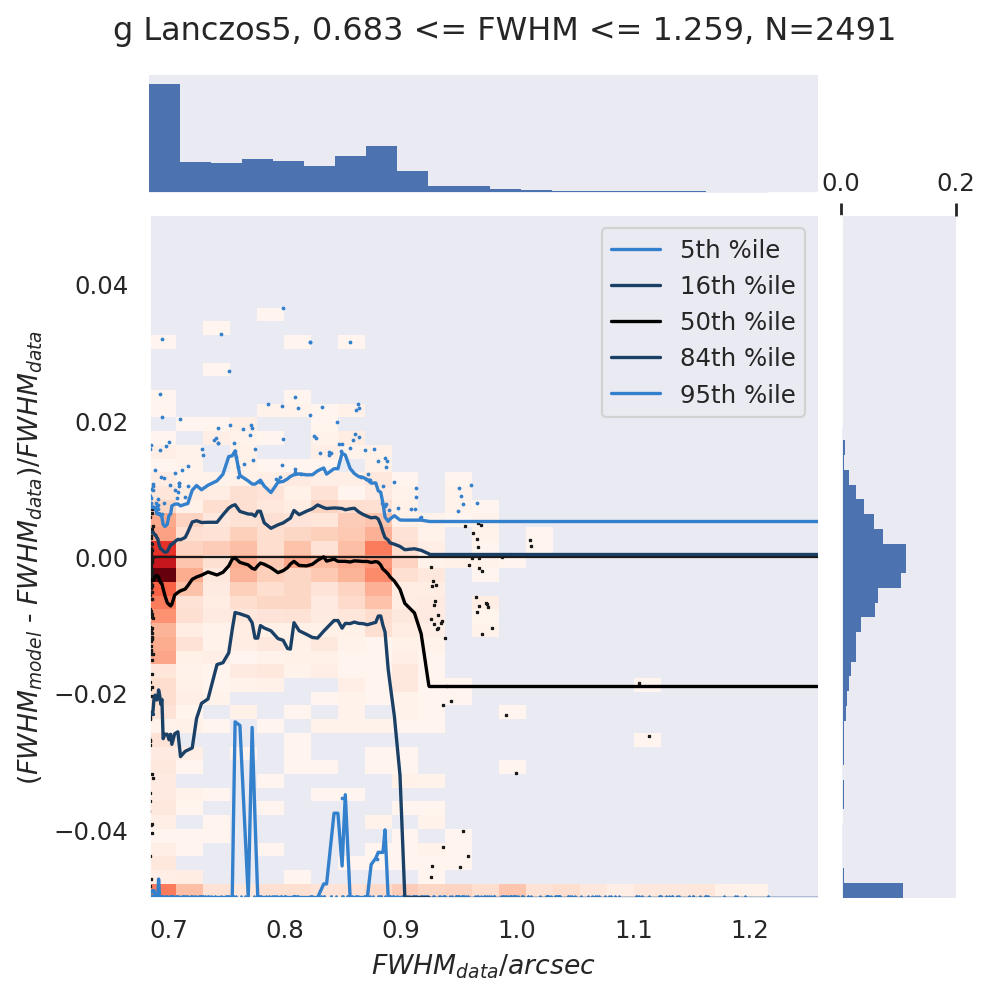

r Lanczos5, 0.379 <= FWHM <= 0.465, N=3919


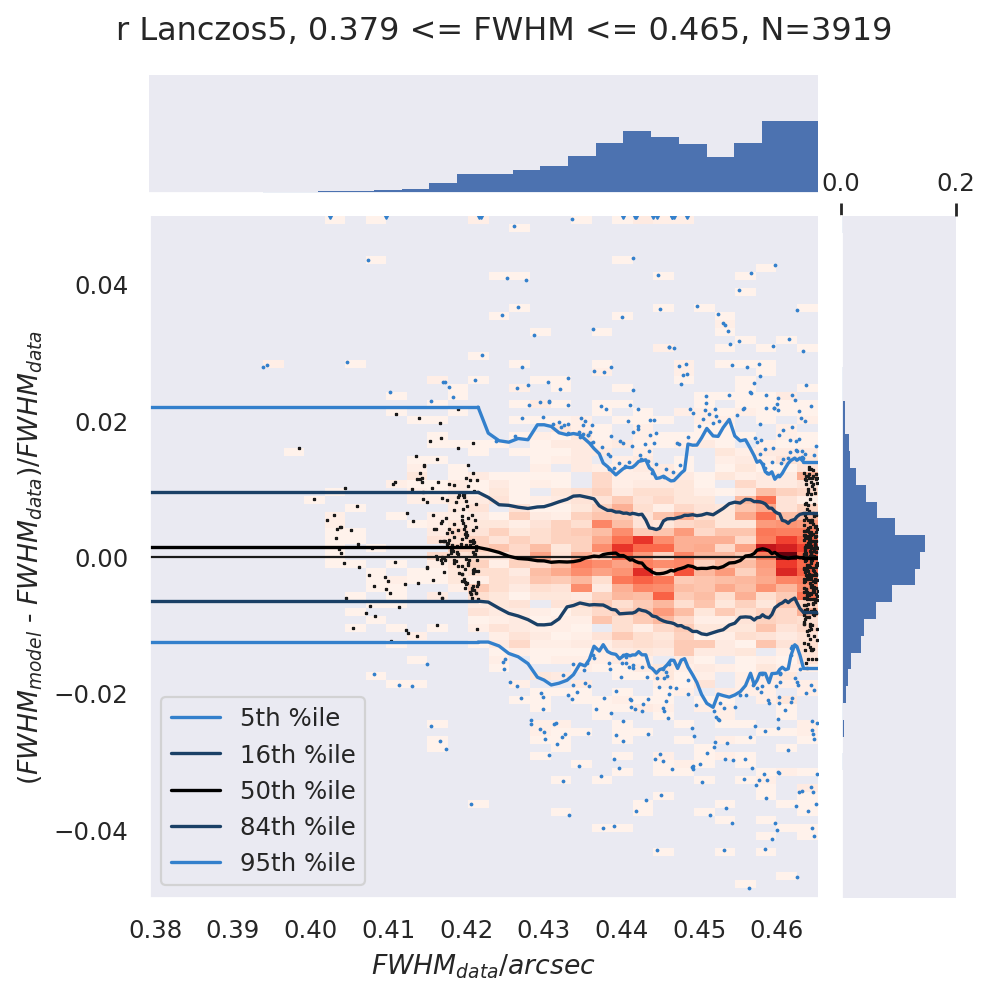

r Lanczos5, 0.465 <= FWHM <= 0.484, N=3919


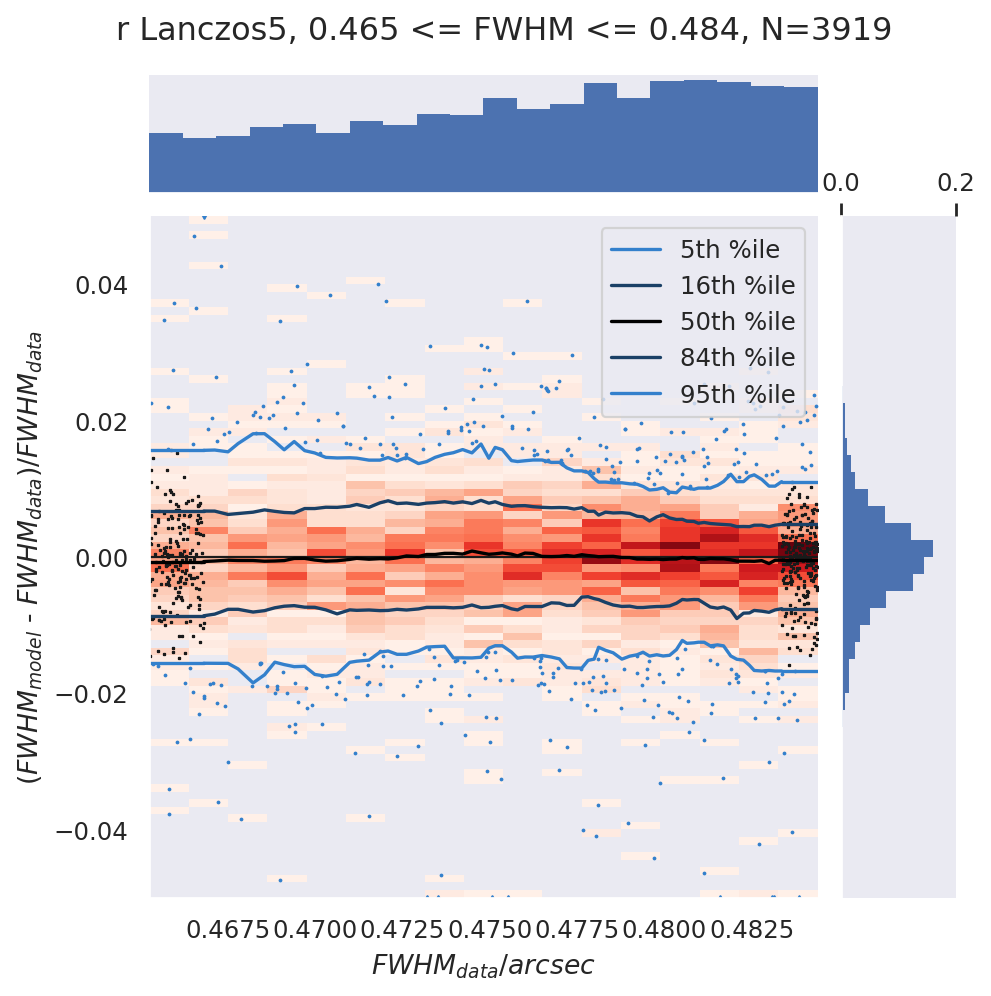

r Lanczos5, 0.484 <= FWHM <= 0.506, N=3919


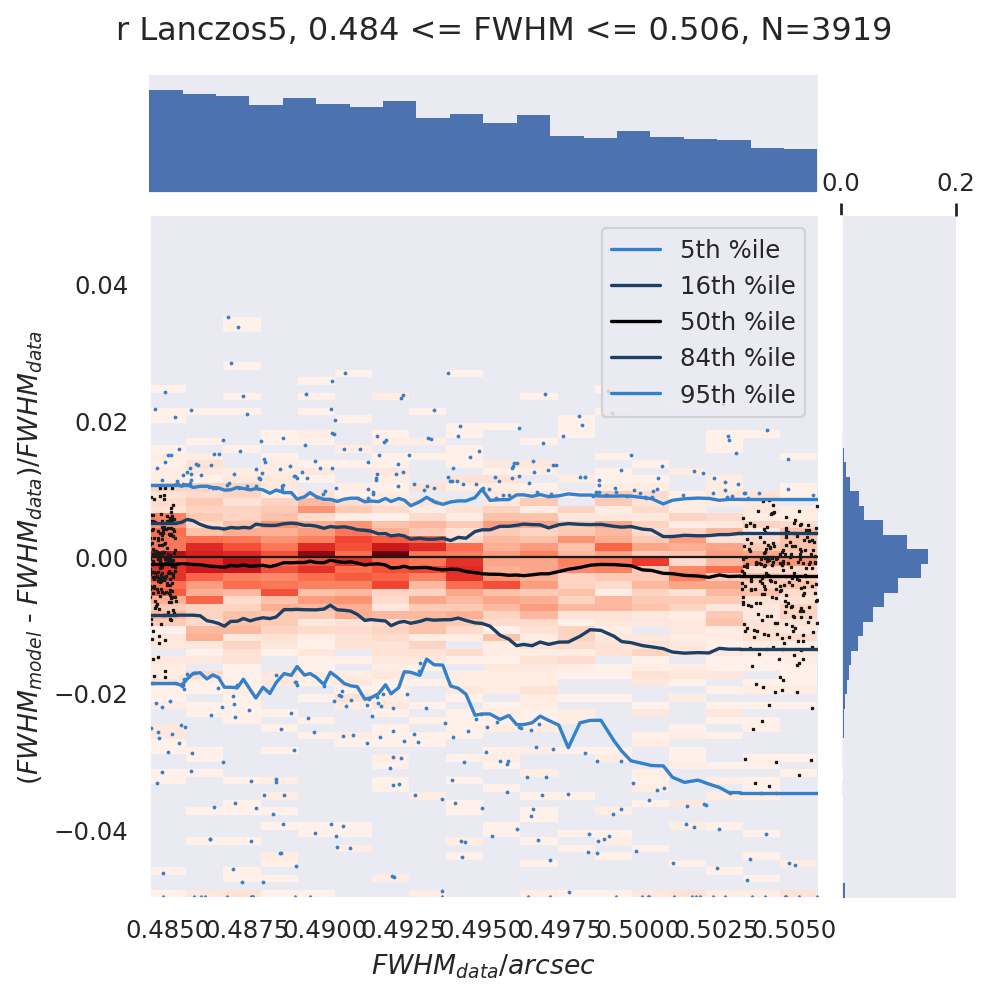

r Lanczos5, 0.506 <= FWHM <= 0.993, N=3919


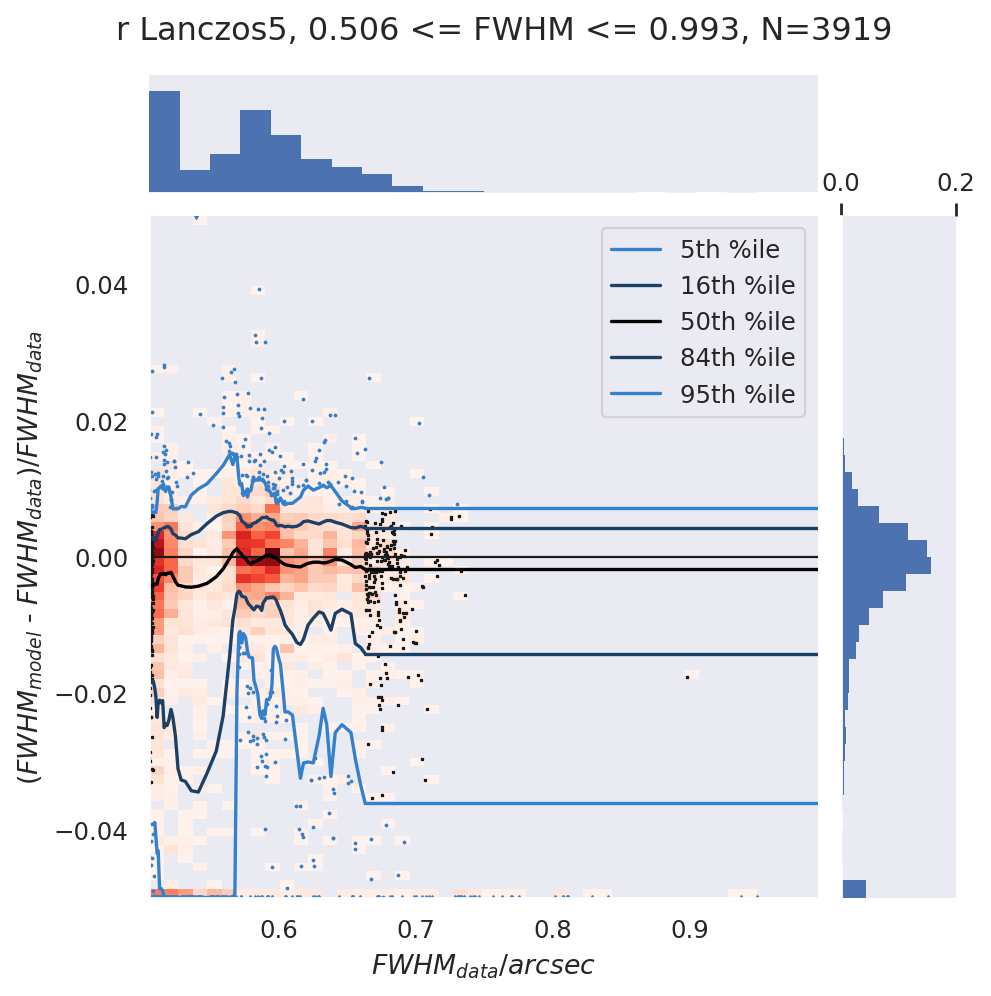

i Lanczos5, 0.405 <= FWHM <= 0.498, N=3344


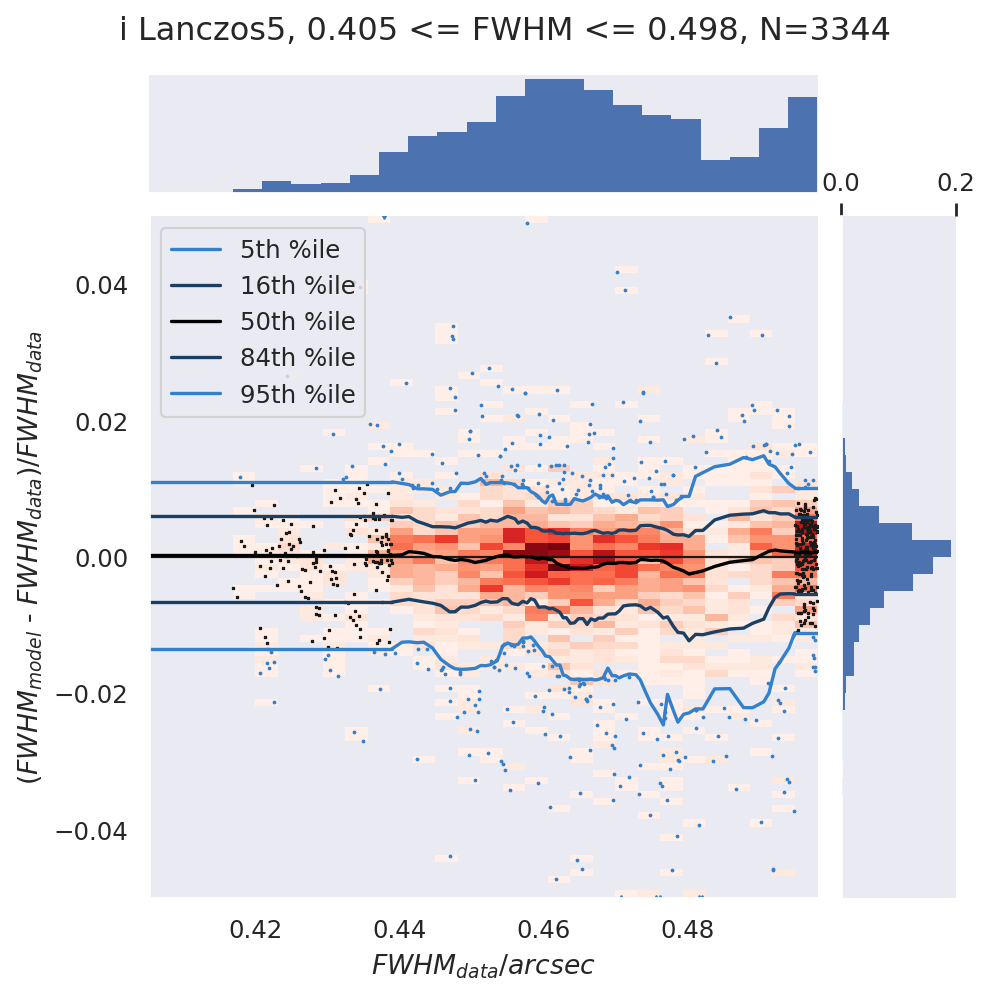

i Lanczos5, 0.498 <= FWHM <= 0.536, N=3344


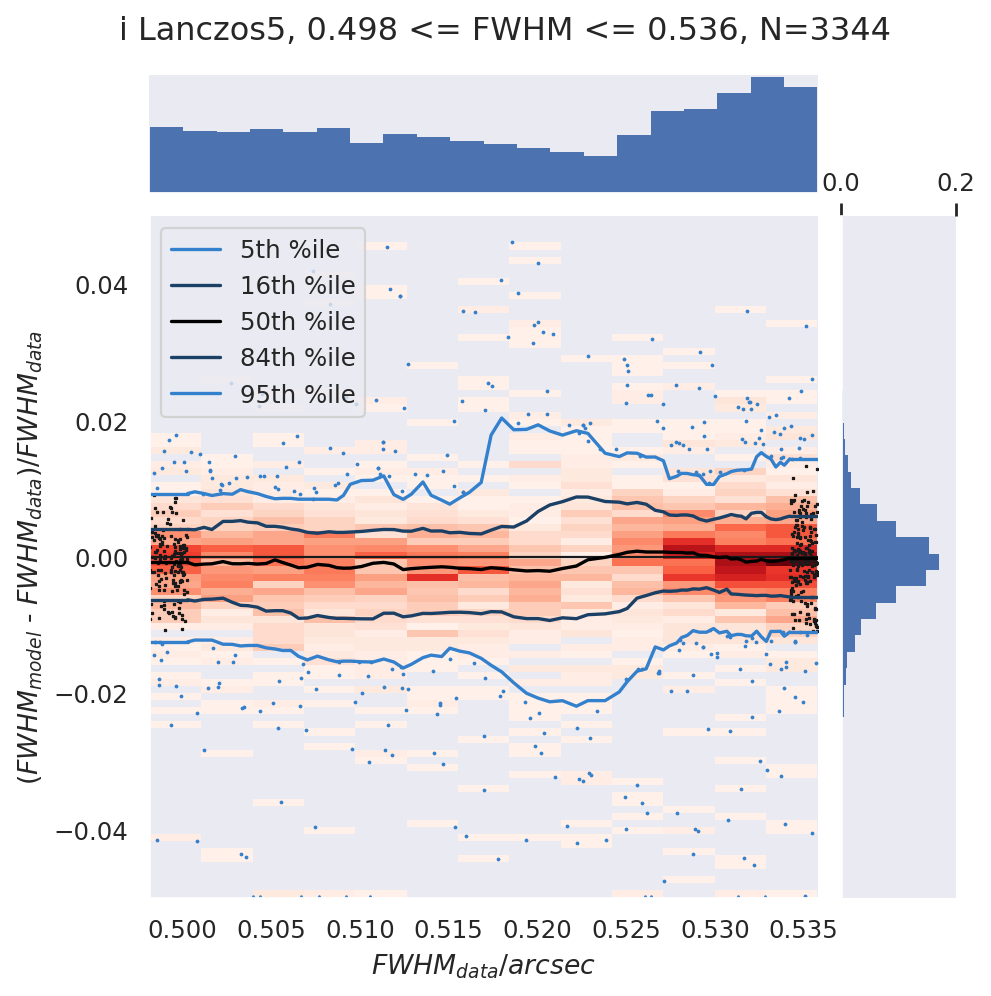

i Lanczos5, 0.536 <= FWHM <= 0.556, N=3343


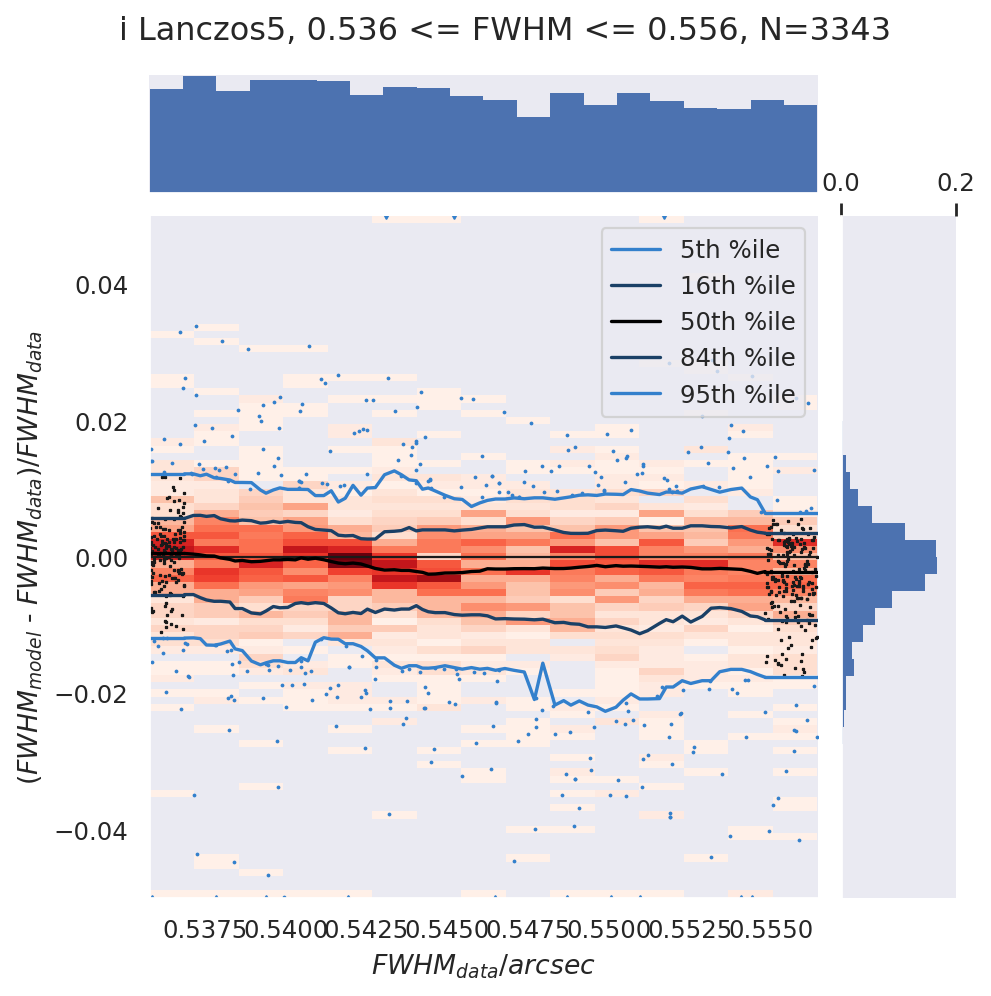

i Lanczos5, 0.556 <= FWHM <= 0.696, N=3344


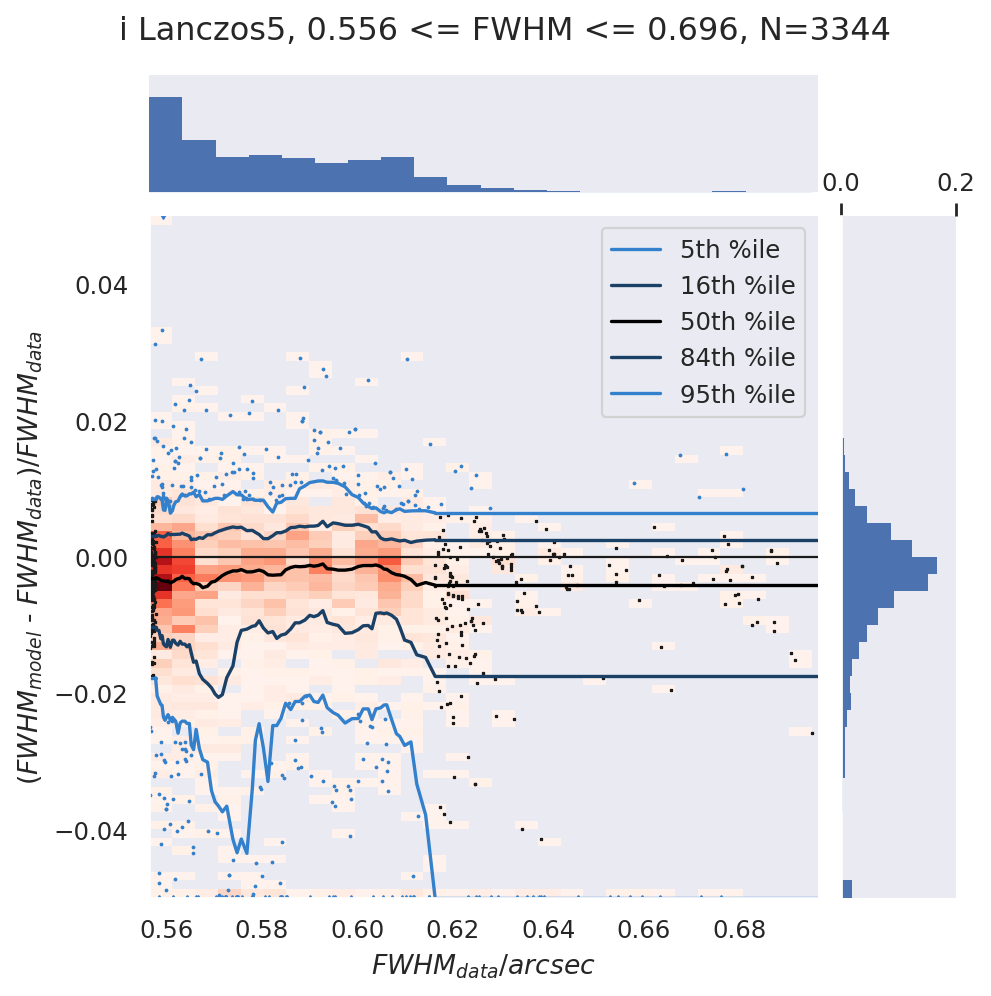

In [9]:
# Plot
kwargs_plotjoint = dict(
    nbinspan = 8,
    densityplot=sns.histplot,
    cmap='Reds',
    limy=limsfrac,
    scatterleft=True,
    scatterright=True,
)
plot_patch = False
labelflux = 'log10(instFluxPsf)'
labelsizeresid = r'($FWHM_{model}$ - $FWHM_{data}$)/$FWHM_{data}$'
labelsize = r'$FWHM_{data}/arcsec$'

for dataplot, typeofdata in ((data, 'Lanczos5'),):
    for band, limx in limxs.items():
        datum = dataplot[band]
        limx = limxs[band]
        x = np.clip(datum['starSize'], limx[0], limx[1])
        sizefrac = (datum['modelSize'] - datum['starSize'])/datum['starSize']
        title=f'{band} {typeofdata} PSF model residuals (N={len(x)})'
        print(title)
        plotjoint_running_percentiles(
            x, sizefrac, limx=limx, ndivisions=32,
            labelx=labelsize, labely=labelsizeresid, title=title,
            **kwargs_plotjoint
        )
        plt.show()
        
for dataplot, typeofdata in ((data, 'Lanczos5'),):
    for band, limx in limxs.items():
        datum = dataplot[band]
        sizefrac = (datum['modelSize'] - datum['starSize'])/datum['starSize']
        condsizefrac = np.isfinite(sizefrac) & np.isfinite(datum['fluxPsf']) & (datum['starSize']<2)
        sizebins = np.sort(datum['starSize'][condsizefrac])[
            np.asarray(np.round(np.linspace(0, np.sum(condsizefrac)-1, num=4+1)), dtype=int)
        ]
        for idx in range(len(sizebins) - 1):
            sizemin, sizemax = sizebins[idx:idx+2]
            cond = condsizefrac & (datum['starSize'] > sizemin) & (datum['starSize'] < sizemax)
            numpoints = np.sum(cond)
            title = f'{band} {typeofdata}, {sizemin:.3f} <= FWHM <= {sizemax:.3f}, N={numpoints}'
            if numpoints >= 100:    
                print(title)
                x = datum['starSize'][cond]
                y = sizefrac[cond]
                plotjoint_running_percentiles(
                    x, y, limx=(sizemin, sizemax), ndivisions=10,
                    labelx=labelsize, labely=labelsizeresid, title=title,
                    **kwargs_plotjoint
                )
                plt.show()
        if plot_patch:
            # TODO: Make sensible plots per patch
            for patch in patches:
                cond = (datum['file'] == patch) & condsizefrac
                grid = sns.jointplot(
                    np.log10(datum['fluxPsf'][cond]), sizefrac[cond], ylim=[-0.1, 0.1],
                    stat_func=None, size=4, s=1, marginal_kws={'bins': 30},
                )
                grid.fig.suptitle(band)